In [2]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection, metrics, ensemble
import pyarrow.parquet as pq
import pickle
import itertools
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.ensemble import BalancedRandomForestClassifier as RandomForestClassifier
from scipy.stats import randint as sp_randint
from sklearn.utils import class_weight
import os

import plotly.graph_objects as go
from astropy.time import Time
from time import time
import json
from json import JSONEncoder

Lectura de Data set de paula

In [3]:
label_file = '../labeled_set_lc_classifier_SanchezSaez_2020.csv'
features_file = '../features_for_lc_classifier_20200609.csv'

# df con el evento (oid) y sus caracteristicas(183)
df_features = pd.read_csv(features_file)

# df con el evento(oid) y su clasificacion por ALeRCE
# df_labels = pd.read_csv(label_file)
df_labels = pd.read_csv(label_file,index_col='oid')



In [4]:
#Descarto valores infinitos
df_features = df_features.replace([np.inf, -np.inf], np.nan)

In [5]:
print('cantidad de eventos etiquetados: ',df_labels['classALeRCE'].values.size)
# df_label.head()
print('-'*10)
print('cantidad de eventos:', len(df_features))
df_features.head()

cantidad de eventos etiquetados:  123496
----------
cantidad de eventos: 868371


,oid,MHAOV_Period_1,MHAOV_Period_2,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,...,W4,W1-W2,W2-W3,r-W3,r-W2,g-W3,g-W2,g-r_ml,delta_period_1,delta_period_2
0,ZTF17aaaaavn,0.106021,0.613572,0.078912,0.097860,0.847902,0.673712,2.0,1.0,0.380952,...,9.426,-0.301,1.491,4.239709,2.748709,5.350475,3.859475,1.110766,0.017990,4.895612e-01
1,ZTF17aaaadjh,0.233443,0.233454,0.493980,0.463765,1.000000,1.000000,1.0,1.0,0.279070,...,8.905,-0.125,2.380,4.533904,2.153904,5.281445,2.901445,0.747541,0.000011,5.197596e-08
2,ZTF17aaaadwo,0.060049,0.216873,0.090708,0.196542,0.903625,0.993806,1.0,1.0,0.368421,...,8.848,-0.065,1.602,4.344352,2.742352,5.495974,3.893974,1.151622,0.423044,2.662193e-01
3,ZTF17aaaajjv,526.315748,555.555529,0.539600,0.566276,1.000000,1.000000,14.0,20.0,0.419580,...,5.957,-0.040,0.997,7.765696,6.768696,10.193531,9.196531,2.427835,29.239637,1.437226e-04
4,ZTF17aaaakjt,0.148265,0.148265,0.564867,0.572449,0.999907,0.990501,1.0,1.0,0.338462,...,9.098,-0.027,0.027,3.161238,3.134238,4.298826,4.271826,1.137588,0.000002,2.169809e-06


In [6]:
# df con los datos de los eventos etiquetados
df_labels.head()

,classALeRCE,ra,dec,source,id_source
oid,,,,,
ZTF19aapcxhy,AGN,154.202.128.520.588,18.723.076.382.352.900,Oh2015,"5,88E+32"
ZTF18abtmwvo,AGN,4.607.405,47.421.185,Oh2015,"5,88E+32"
ZTF18acvgdfy,AGN,1.344.074.091.833.330,5.472.595.541.666.660,Oh2015,"5,88E+32"
ZTF19aabvjsi,AGN,13.235.329.823.749.900,140.672.658.875,Oh2015,"5,88E+32"
ZTF18aadyxlg,AGN,12.557.700.387,33.091.120.309.999.900,Oh2015,"5,88E+32"


In [7]:
#defining taxonomy tree according to the taxonomy presented in Section 2.2 of the paper.
df_labels['class_original'] = df_labels['classALeRCE']

#defining the classes included in the RF model

label_order = ['SNIa', 'SNIbc', 'SNII', 'SLSN','QSO','AGN', 'Blazar', 'YSO','CV/Nova',
               'LPV', 'E', 'DSCT', 'RRL', 'CEP','Periodic-Other']

labels = df_labels.loc[df_labels.class_original.isin(label_order)][["class_original"]]

#defining hierarchical classes:

labels['class_hierachical'] = labels['class_original']

labels.loc[ (labels['class_hierachical'] == 'LPV') | (labels['class_hierachical'] == 'Periodic-Other') | (labels['class_hierachical'] == 'E')  | (labels['class_hierachical'] == 'DSCT') | (labels['class_hierachical'] == 'RRL') | (labels['class_hierachical'] == 'CEP') , 'class_hierachical'] = 'Periodic'

labels.loc[(labels['class_hierachical'] == 'SNIa') | (labels['class_hierachical'] == 'SNIbc') | (labels['class_hierachical'] == 'SNII') | (labels['class_hierachical'] == 'SLSN'), 'class_hierachical'] = 'Transient'

labels.loc[(labels['class_hierachical'] == 'CV/Nova')  |(labels['class_hierachical'] == 'YSO') |     (labels['class_hierachical'] == 'AGN') |  (labels['class_hierachical'] == 'QSO') | (labels['class_hierachical'] == 'Blazar')  , 'class_hierachical'] = 'Stochastic'

cm_classes_hierachical = ['Transient','Stochastic','Periodic']
cm_classes_original = label_order

print(labels['class_hierachical'].values.shape)

# labels = labels.rename_axis(None,axis=0)
# labels = labels.set_axis('oid',axis=0)
print(len(labels))
labels = labels.reset_index()
labels.head()

(123496,)
123496


,oid,class_original,class_hierachical
0,ZTF19aapcxhy,AGN,Stochastic
1,ZTF18abtmwvo,AGN,Stochastic
2,ZTF18acvgdfy,AGN,Stochastic
3,ZTF19aabvjsi,AGN,Stochastic
4,ZTF18aadyxlg,AGN,Stochastic


In [8]:
print('df_feautes: ', len(df_features))
print('df_labels: ',len(df_labels))
print('-'*50)
print('eventos unicos df_features: ', len(df_features.oid.unique()))
print('eventos unicos labels: ', len(labels.oid.unique()))

df_feautes:  868371
df_labels:  123496
--------------------------------------------------
eventos unicos df_features:  868371
eventos unicos labels:  123496


In [ ]:
unique_labels = labels.oid.unique()
print(f'unique_labels: {len(unique_labels)}')
limit = 10000

event_features_labels = []
start_time = time()

for index,event in enumerate(unique_labels):
    # print(index,event)
    same_event = df_features.loc[df_features['oid'] == event].oid.values[0]
    # print(index,same_event)
    event_features_labels.append(same_event)

    if(index == limit-1):
        break

end_time = time() - start_time
print(f'time: {end_time}')
# print(f'event: {event_features_labels}')
print(f'total event: {len(event_features_labels)}')


guardar los eventos compartidos entre df_features y labels (caracteristicas y etiquetas)

In [90]:
class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

same_event_json = {'name_event': event_features_labels}

output = json.dumps(same_event_json, cls=NumpyArrayEncoder)

with open('same_event_features_labels.json', 'w') as outfile:
    outfile.write(output)

In [9]:
# grupo 10.000
with open('same_event_features_labels.json','r') as group:
    firt_group = json.load(group)

event_features_labels = firt_group['name_event']
print('eventos iguales entre features y labels: ',len(event_features_labels))

eventos iguales entre features y labels:  10000


-------

In [10]:
labels = labels.set_axis(['oid','class_original', 'class_hierachical'],axis='columns')

In [11]:
for index, class_alerce in enumerate(label_order):
   print(index+1,class_alerce, labels['class_original'][labels['class_original']==class_alerce].shape[0])

1 SNIa 1272
2 SNIbc 94
3 SNII 328
4 SLSN 24
5 QSO 26168
6 AGN 4667
7 Blazar 1267
8 YSO 1740
9 CV/Nova 871
10 LPV 14076
11 E 37901
12 DSCT 732
13 RRL 32482
14 CEP 618
15 Periodic-Other 1256


Counter({'E': 37901, 'RRL': 32482, 'QSO': 26168, 'LPV': 14076, 'AGN': 4667, 'YSO': 1740, 'SNIa': 1272, 'Blazar': 1267, 'Periodic-Other': 1256, 'CV/Nova': 871, 'DSCT': 732, 'CEP': 618, 'SNII': 328, 'SNIbc': 94, 'SLSN': 24})
                number
E                37901
RRL              32482
QSO              26168
LPV              14076
AGN               4667
YSO               1740
SNIa              1272
Blazar            1267
Periodic-Other    1256
CV/Nova            871
DSCT               732
CEP                618
SNII               328
SNIbc               94
SLSN                24


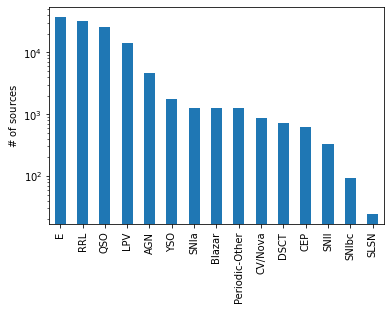

In [12]:
#plotting the number of sources per class for the labeled set
class_counts = Counter(labels['class_original'])
class_counts.most_common()
print(class_counts)
df_hist = pd.DataFrame.from_dict(class_counts, orient='index',columns=['number'])
df_hist = df_hist.sort_values(by=['number'],ascending=False)
print(df_hist)
df_hist.plot(kind='bar',legend=False)

plt.yscale('log')
plt.ylabel(r'$\#$ of sources')
plt.savefig('number_sources_labeled_set.pdf',bbox_inches='tight')

-------------------------------------------------

Lectura de data set exp3


In [13]:
parquet_file = pq.ParquetFile('../lightcurves_ts.parquet')
print("numero de columnas:", parquet_file.metadata.num_columns)
print("numero de filas (datos): ", parquet_file.metadata.num_rows)

data = parquet_file.read_row_group(0, ['oid', 'fid', 'mjd', 'magpsf_corr', 'sigmapsf_corr', 'classALeRCE']).to_pandas()
print('cantidad de eventos: ',len(data.oid.unique()))
print('-'*10)

data.head()


numero de columnas: 113
numero de filas (datos):  13844917
cantidad de eventos:  173693
----------


,oid,fid,mjd,magpsf_corr,sigmapsf_corr,classALeRCE
0,ZTF17aaacfxu,1,58863.138021,20.996371,0.444790,RRL
1,ZTF17aaacfxu,1,58867.179803,19.374605,0.175861,RRL
2,ZTF17aaacfxu,1,58871.170336,19.630466,0.123111,RRL
3,ZTF17aaacfxu,1,58880.146204,19.362001,0.103466,RRL
4,ZTF17aaacfxu,1,58849.131389,19.530453,0.078387,RRL


In [14]:
# limpieza de datos 
df_data = data.replace([np.inf, -np.inf], np.nan)
df_data = df_data.dropna()

print(df_data['classALeRCE'].values.size)
df_data.head()

13697564


,oid,fid,mjd,magpsf_corr,sigmapsf_corr,classALeRCE
0,ZTF17aaacfxu,1,58863.138021,20.996371,0.444790,RRL
1,ZTF17aaacfxu,1,58867.179803,19.374605,0.175861,RRL
2,ZTF17aaacfxu,1,58871.170336,19.630466,0.123111,RRL
3,ZTF17aaacfxu,1,58880.146204,19.362001,0.103466,RRL
4,ZTF17aaacfxu,1,58849.131389,19.530453,0.078387,RRL


In [15]:
# muestra los eventos unicos, sin repeticiones
all_event = df_data.oid.unique()

print('eventos totales',all_event.shape)
print(all_event)

eventos totales (170706,)
['ZTF17aaacfxu' 'ZTF17aaaczwj' 'ZTF17aaaemke' ... 'ZTF20abgdwuf'
 'ZTF20abhagts' 'ZTF20abiqqow']


----------------

Eventos iguales entre event_features_labels(paula) y all_event(exp3)

In [16]:
print(f'eventos iguales entre features y labels: {len(event_features_labels)}')
print(f'eventos totales en all event (exp3): {len(all_event)}')
print(all_event)


eventos iguales entre features y labels: 10000
eventos totales en all event (exp3): 170706
['ZTF17aaacfxu' 'ZTF17aaaczwj' 'ZTF17aaaemke' ... 'ZTF20abgdwuf'
 'ZTF20abhagts' 'ZTF20abiqqow']


In [17]:
# convertir a dataframe los arreglos de event_features_labels y all_event
df_event_features_labels = pd.DataFrame(event_features_labels,columns=['oid'])
df_all_event = pd.DataFrame(all_event,columns=['oid'])

df_event_features_labels.head()
# df_all_event.head()

,oid
0,ZTF19aapcxhy
1,ZTF18abtmwvo
2,ZTF18acvgdfy
3,ZTF19aabvjsi
4,ZTF18aadyxlg


In [144]:
limit = 10000

all_same_event = []
start_time = time()

for index,event in enumerate(event_features_labels):
    same_event = df_all_event.loc[df_all_event['oid'] == event].oid.values[0]
    # print(index,same_event)
    all_same_event.append(same_event)

    if(index == limit-1):
        break

end_time = time() - start_time
print(f'time: {end_time}')
# print(f'event: {event_features_labels}')
# print(f'total event: {len(event_features_labels)}')


time: 59.61556673049927


In [145]:
class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

same_event_json = {'name_event': all_same_event}

output = json.dumps(same_event_json, cls=NumpyArrayEncoder)

with open('./exp4/same_event_fl_exp3.json', 'w') as outfile:
    outfile.write(output)

In [18]:
# grupo 10.000
with open('./exp4/same_event_fl_exp3.json','r') as group:
    firt_group = json.load(group)

all_event_oid = firt_group['name_event']
print('eventos iguales entre features y labels: ',len(all_event_oid))

eventos iguales entre features y labels:  10000


Testear si se duplicaron eventos

In [19]:
# convertir a dataframe los arreglos de all_event_oid
df_all_event_oid = pd.DataFrame(all_event_oid,columns=['oid'])
print(f'eventos unicos: {len(df_all_event_oid.oid.unique())}')
df_all_event_oid.head()


eventos unicos: 10000


,oid
0,ZTF19aapcxhy
1,ZTF18abtmwvo
2,ZTF18acvgdfy
3,ZTF19aabvjsi
4,ZTF18aadyxlg


------

Funciones para obtener los tensores

In [49]:
def getStatistic(index,indBin,magnitud, amount_bins):
    #Analisis en base a la magnitud
    mag_ordered = magnitud[index]
    
    #Obtención de vectores con caracteristicas estadisticas
    vector_mean = np.array([np.nanmean(mag_ordered[indBin==(i+1)])  if (indBin==(i+1)).sum()>0 else -1000  for i in range(amount_bins)])
    vector_max = np.array([np.nanmax(mag_ordered[indBin==(i+1)])  if (indBin==(i+1)).sum()>0 else -1000 for i in range(amount_bins)])
    vector_min = np.array([np.nanmin(mag_ordered[indBin==(i+1)])  if (indBin==(i+1)).sum()>0 else -1000 for i in range(amount_bins)])
    vector_std = np.array([np.nanstd(mag_ordered[indBin==(i+1)])  if (indBin==(i+1)).sum()>0 else -1000 for i in range(amount_bins)])

    return [vector_mean,vector_max,vector_min,vector_std]

    

def drawGraphic(bins,time,mag,indice,period):
    title_figure = f'Folded Time Serie with period T/{period}'
    #Grafico para ver la serie de tiempo 
    plt.figure(figsize=(12,4))
    plt.plot(time[indice], mag[indice])
    plt.scatter(time[indice], mag[indice])
    plt.ylabel("Magnitud")
    plt.xlabel("Time")
    plt.suptitle(title_figure, fontsize=22)
    plt.grid(axis='x', color='red', linestyle='-', linewidth=2)

    for bin in bins:
        plt.axvline(x=bin,color='red')
    # plt.grid(axis='y', color='gray', linestyle='dashed')
    plt.show()


def variantion_period_v2(array_periods,ts_time, ts_mag, amount_bins=10):
    tensor_data = []
    for period in array_periods:
        #valor del periodo en decimales
        period_float = 1 / period
        #proceso de folding
        folded_time = ts_time % period_float
        # print('folded_time',folded_time)

        #indices de los datos para encontrarlos luego del folding
        index_folded = np.argsort(folded_time)
        # print('index_folded',index_folded)

        #Divido el periodo en bins o intervalos [0,n] para luego obtener datos estadisticos de cada bin
        bins = np.linspace(0,period_float,amount_bins+1)
        #Concentración de datos en cada bin
        concentration, bin_edges= np.histogram(folded_time[index_folded],bins=bins)
        #indices - Devuelve los índices de los bins a los que pertenece cada valor del folded_time
        index_bin = np.digitize(folded_time[index_folded],bins=bins)

        # print("bins: ",bins)
        # print("concentracion de datos en cada bin: ",concentration)
        #Obtención de datos estadisticos de cada bin y formación del tensor
        vectorStatisticPeriod = np.asmatrix(getStatistic(index_folded,index_bin,ts_mag,amount_bins))
        tensor_data.append(vectorStatisticPeriod)

    return tensor_data

# funcion para graficar la serie de tiempo con link al sitio web de ALeRCE del evento
def GraphicLightCurve(fig,band,light_curve,show):
    mtcolor = [['g','green'],['r','red'],['b','blue']]
    idx=(light_curve['fid']==band).values
    fig.add_trace(
            go.Scatter(
                x = light_curve.mjd.values[idx],
                y = light_curve.magpsf_corr.values[idx],
                mode = 'markers', name=mtcolor[band-1][0],
                marker_color = mtcolor[band-1][1],
                error_y = dict(type='data', array=light_curve.sigmapsf_corr.values[idx], visible=True),
                marker = dict(size=10, opacity=0.5, showscale=False, line=dict(width=1)), 
                showlegend = True,
                legendgroup = mtcolor[band-1][0],
                hovertemplate ='<b>' + mtcolor[band-1][0] + ':\t\t</b>' + light_curve.magpsf_corr[idx].map('{:.3f}'.format).apply(str) + ' ± ' +
                                light_curve.sigmapsf_corr[idx].map('{:.3f}'.format).apply(str)  + '<br>' + 
                                '<b>MJD:\t</b>'+ light_curve.mjd[idx].apply(str)  + '<br>' + 
                                '<b>Date:\t</b>'+ [temp.strftime('%a, %d %b %Y %H:%M:%S UTC') for temp in Time(light_curve.mjd[idx].values, format='mjd').datetime]+ '<br>' +
                                '<extra></extra>'
                ))
    # fig['layout']['yaxis']['autorange'] = "reversed"
    fig.update_xaxes(
        tickangle=0,
        title_text="Modified Julian Dates [MJD]",
        title_font={"size": 14})
    
    fig.update_yaxes(
        autorange= 'reversed',
        tickangle=0,
        title_text="Magnitude [Mag]",
        title_font={"size": 14})
    
    fig.update_layout(
        title={'text':'<b>Light Curve</b>' + '<br>' +
                        '<a href="https://alerce.online/object/'+ event + '">Object: ' + event + 'text</a>',
                'font':dict(size=14),'x':0.5, 'y':0.9,'xanchor': 'center','yanchor': 'top'})
    
    if_show_fig = lambda show: fig.show() if show == True else False
    if_show_fig(show)

------------

Teniendo los eventos que se comparten entre df_features y df_labels, y estos que a su vez se comparten con los del data set del exp3, se procede a verificar cuantos de estos tienen datos en la banda g (fid = 1)

Se obtiene el tensor con las caracteristicas

In [21]:
df_features.loc[df_features.oid == 'ZTF17aaacfxu']

,oid,MHAOV_Period_1,MHAOV_Period_2,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,...,W4,W1-W2,W2-W3,r-W3,r-W2,g-W3,g-W2,g-r_ml,delta_period_1,delta_period_2


In [59]:
all_event_unique = data.oid.unique()
print(f'largo lista de eventos: {len(all_event_unique)}')

print(f'lista de eventos: {all_event_unique}')
t = 0
test = all_event_unique[t:]
print(f'test largo: {len(test)}')
print(f'lista de eventos: {test}')




largo lista de eventos: 173693
lista de eventos: ['ZTF17aaacfxu' 'ZTF17aaaczwj' 'ZTF17aaaemke' ... 'ZTF20abgdwuf'
 'ZTF20abhagts' 'ZTF20abiqqow']
test largo: 173693
lista de eventos: ['ZTF17aaacfxu' 'ZTF17aaaczwj' 'ZTF17aaaemke' ... 'ZTF20abgdwuf'
 'ZTF20abhagts' 'ZTF20abiqqow']


In [71]:
all_event_unique = data.oid.unique()
print(len(all_event_unique))

init = 0
finish = 10000
num_periods = 4
nbines = 10
array_periods = 2**(np.arange(num_periods)+0)
# -----------------------------------
all_columns = df_features.columns.values.tolist()
all_columns.append('Tensor')
df_features_tensor = pd.DataFrame(columns=all_columns)
amount_event = 0
# -----------------------------------
all_event_unique = all_event_unique[init:]

start_time = time()

for index,event in enumerate(all_event_unique):
    # print(index,event)
    
    # se buscan los eventos que coinciden con los del exp3
    same_event = df_data.loc[df_data['oid'] == event]
    rows_event, cols_event = same_event.shape
    if(rows_event == 1):
        continue

    get_features = df_features.loc[df_features['oid'] == event]
    rows_ft, cols_ft = get_features.shape
    if(rows_ft == 0):
        continue
    
    # de los eventos encontrados se obtiene solo los datos con fid 1
    event_band = same_event.loc[same_event['fid'] == 1]
    if(event_band.empty is True):
        continue

    # se obtiene el tensor
    min_mjd = event_band['mjd'].values.min()
    max_mjd = event_band['mjd'].values.max()
    time_normalized = (event_band['mjd'].values - min_mjd)/(max_mjd - min_mjd)
    # tensor con caracteristicas de cada filtro
    tensor = np.array(variantion_period_v2(array_periods, time_normalized, event_band['magpsf_corr'].values, nbines))
    

    # print('tensor',tensor.shape)
    # se deja el tensor en un solo arreglo (160 valores por cada arreglo)
    # tensor_ravel = np.ravel(tensor)
    # print(index,event,tensor_ravel.shape)

    get_features=get_features.assign(Tensor = [ (np.array(np.ravel(tensor)))])
    df_features_tensor = pd.concat([df_features_tensor,get_features], axis=0)
    amount_event+=1
    # test.append(get_features.values)
    # display(get_features)

    if(index == finish-1):
        break

end_time = time() - start_time
print(f'time: {end_time}')
print(f'cantidad de eventos: {amount_event}')
# print(f'event: {event_features_labels}')
# print(f'total event: {len(event_features_labels)}')

173693


C:\Users\Leonardo Peña\AppData\Local\Temp\ipykernel_13940\1789517709.py:41: RuntimeWarning: invalid value encountered in true_divide
  time_normalized = (event_band['mjd'].values - min_mjd)/(max_mjd - min_mjd)
C:\Users\Leonardo Peña\AppData\Local\Temp\ipykernel_13940\1789517709.py:41: RuntimeWarning: invalid value encountered in true_divide
  time_normalized = (event_band['mjd'].values - min_mjd)/(max_mjd - min_mjd)
C:\Users\Leonardo Peña\AppData\Local\Temp\ipykernel_13940\1789517709.py:41: RuntimeWarning: invalid value encountered in true_divide
  time_normalized = (event_band['mjd'].values - min_mjd)/(max_mjd - min_mjd)
C:\Users\Leonardo Peña\AppData\Local\Temp\ipykernel_13940\1789517709.py:41: RuntimeWarning: invalid value encountered in true_divide
  time_normalized = (event_band['mjd'].values - min_mjd)/(max_mjd - min_mjd)
C:\Users\Leonardo Peña\AppData\Local\Temp\ipykernel_13940\1789517709.py:41: RuntimeWarning: invalid value encountered in true_divide
  time_normalized = (event_

time: 4775.337683439255
cantidad de eventos: 6933


-----

df_features_tensor = contiene todas las caracteristicas más el tensor generado por los datos de la banda 1 (g)

In [76]:
print(f'total unicos test: {len(df_features_tensor)}')
df_features_tensor.head()

total unicos test: 6933


,oid,MHAOV_Period_1,MHAOV_Period_2,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,...,W1-W2,W2-W3,r-W3,r-W2,g-W3,g-W2,g-r_ml,delta_period_1,delta_period_2,Tensor
356171,ZTF17aaaemke,0.135942,0.13594,0.319945,0.266913,0.999845,0.999997,1.0,1.0,0.361111,...,-0.025,1.044,3.225166,2.181166,4.193614,3.149614,0.968448,0.000002,0.0,"[16.480348304504584, 16.594742591837075, -1000..."
80499,ZTF17aaafyya,0.151124,0.151126,0.376849,0.347666,1.0,1.0,1.0,1.0,0.421875,...,-0.046,0.244,2.550194,2.306194,3.454954,3.210954,0.90476,0.000002,0.0,"[15.463004260280721, 15.512297104173507, 15.48..."
367823,ZTF17aaageae,0.818733,0.818867,0.218249,0.327319,1.0,0.999997,1.0,1.0,0.4,...,0.023,0.629,1.937573,1.308573,2.133469,1.504469,0.195896,0.000067,0.000067,"[14.662889029902558, 14.510575719003672, -1000..."
498283,ZTF17aaaivsr,0.134073,0.134073,0.344626,0.30527,0.999993,0.821926,1.0,1.0,0.384615,...,-0.06,1.885,4.006276,2.121276,4.565984,2.680984,0.559708,0.000002,0.000002,"[16.869307808290692, 16.881669427435572, 16.66..."
859841,ZTF17aaaizej,0.591017,0.590947,0.660175,0.404425,1.0,1.0,1.0,1.0,0.317073,...,0.009,2.871,4.185692,1.314692,4.359793,1.488793,0.1741,0.0,0.00007,"[16.437525530064953, 16.8584739452951, 16.5229..."


Guardar df_features_tensor en un archivo csv 

In [75]:
df_features_tensor.to_csv('./exp4/features_with_tensor_exp4_6900.csv')

Leer el csv generado anteriormente

In [91]:

df_features_tensor = pd.read_csv('./exp4/features_exp4_4x4x10.csv')
df_features_tensor.head()


,Unnamed: 0,oid,MHAOV_Period_1,MHAOV_Period_2,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,...,W1-W2,W2-W3,r-W3,r-W2,g-W3,g-W2,g-r_ml,delta_period_1,delta_period_2,Tensor
0,356171,ZTF17aaaemke,0.135942,0.135940,0.319945,0.266913,0.999845,0.999997,1.0,1.0,...,-0.025,1.044,3.225166,2.181166,4.193614,3.149614,0.968448,1.885743e-06,4.405883e-08,[ 1.64803483e+01 1.65947426e+01 -1.00000000e+...
1,80499,ZTF17aaafyya,0.151124,0.151126,0.376849,0.347666,1.000000,1.000000,1.0,1.0,...,-0.046,0.244,2.550194,2.306194,3.454954,3.210954,0.904760,2.254299e-06,3.267149e-08,[15.46300426 15.5122971 15.48937004 15.857546...
2,367823,ZTF17aaageae,0.818733,0.818867,0.218249,0.327319,1.000000,0.999997,1.0,1.0,...,0.023,0.629,1.937573,1.308573,2.133469,1.504469,0.195896,6.688907e-05,6.721974e-05,[ 1.46628890e+01 1.45105757e+01 -1.00000000e+...
3,498283,ZTF17aaaivsr,0.134073,0.134073,0.344626,0.305270,0.999993,0.821926,1.0,1.0,...,-0.060,1.885,4.006276,2.121276,4.565984,2.680984,0.559708,1.782890e-06,1.782890e-06,[ 1.68693078e+01 1.68816694e+01 1.66658520e+...
4,859841,ZTF17aaaizej,0.591017,0.590947,0.660175,0.404425,1.000000,1.000000,1.0,1.0,...,0.009,2.871,4.185692,1.314692,4.359793,1.488793,0.174100,4.163987e-08,6.982180e-05,[ 1.64375255e+01 1.68584739e+01 1.65229784e+...


In [82]:
ft_oid = df_features_tensor.oid.unique()
len_df = len(df_features_tensor.oid.unique())
print(f'total eventos unicos: {len_df}')

df_labels_features = labels.merge(df_features_tensor,on='oid', how='right')
print(f'test len: {len(df_labels_features)}')
df_labels_features.head()

total eventos unicos: 6933
test len: 6933


,oid,class_original,class_hierachical,Unnamed: 0,MHAOV_Period_1,MHAOV_Period_2,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,...,W1-W2,W2-W3,r-W3,r-W2,g-W3,g-W2,g-r_ml,delta_period_1,delta_period_2,Tensor
0,ZTF17aaaemke,E,Periodic,356171,0.135942,0.135940,0.319945,0.266913,0.999845,0.999997,...,-0.025,1.044,3.225166,2.181166,4.193614,3.149614,0.968448,1.885743e-06,4.405883e-08,[ 1.64803483e+01 1.65947426e+01 -1.00000000e+...
1,ZTF17aaafyya,E,Periodic,80499,0.151124,0.151126,0.376849,0.347666,1.000000,1.000000,...,-0.046,0.244,2.550194,2.306194,3.454954,3.210954,0.904760,2.254299e-06,3.267149e-08,[15.46300426 15.5122971 15.48937004 15.857546...
2,ZTF17aaageae,RRL,Periodic,367823,0.818733,0.818867,0.218249,0.327319,1.000000,0.999997,...,0.023,0.629,1.937573,1.308573,2.133469,1.504469,0.195896,6.688907e-05,6.721974e-05,[ 1.46628890e+01 1.45105757e+01 -1.00000000e+...
3,ZTF17aaaivsr,E,Periodic,498283,0.134073,0.134073,0.344626,0.305270,0.999993,0.821926,...,-0.060,1.885,4.006276,2.121276,4.565984,2.680984,0.559708,1.782890e-06,1.782890e-06,[ 1.68693078e+01 1.68816694e+01 1.66658520e+...
4,ZTF17aaaizej,RRL,Periodic,859841,0.591017,0.590947,0.660175,0.404425,1.000000,1.000000,...,0.009,2.871,4.185692,1.314692,4.359793,1.488793,0.174100,4.163987e-08,6.982180e-05,[ 1.64375255e+01 1.68584739e+01 1.65229784e+...


                number
E                 2166
RRL               1806
QSO               1518
LPV                783
AGN                252
YSO                 77
Blazar              75
Periodic-Other      71
DSCT                49
CV/Nova             42
SNIa                36
NaN                 11
SNIbc                3


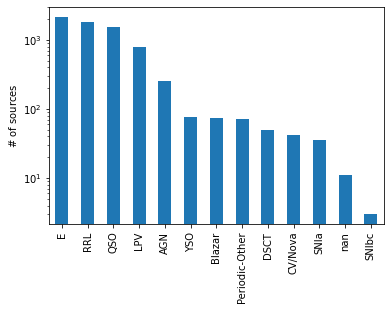

In [90]:
#defining the classes included in the RF model
label_order = ['SNIa', 'SNIbc', 'SNII', 'SLSN','QSO','AGN', 'Blazar', 'YSO','CV/Nova',
               'LPV', 'E', 'DSCT', 'RRL', 'CEP','Periodic-Other']

# for index, class_alerce in enumerate(label_order):
#    print(index+1,'-',class_alerce, df_labels_features['class_original'][df_labels_features['class_original']==class_alerce].shape[0])

# print('-'*10)

#plotting the number of sources per class for the labeled set
class_counts = Counter(df_labels_features['class_original'])
class_counts.most_common()
# print(class_counts)
df_hist = pd.DataFrame.from_dict(class_counts, orient='index',columns=['number'])
df_hist = df_hist.sort_values(by=['number'],ascending=False)
print(df_hist)
df_hist.plot(kind='bar',legend=False)

plt.yscale('log')
plt.ylabel(r'$\#$ of sources')
plt.savefig('number_sources_labeled_set.pdf',bbox_inches='tight')

In [85]:
label_order = ['E', 'RRL', 'QSO', 'LPV','AGN', 'YSO', 'Blazar','CV/Nova','DSCT', 'CEP','Periodic-Other','SNIa']
df_labels_features = df_labels_features[(df_labels_features.class_original != 'SNII') & (df_labels_features.class_original != 'CEP') ]

for index, class_alerce in enumerate(label_order):
   print(index+1,'-',class_alerce, df_labels_features['class_original'][df_labels_features['class_original']==class_alerce].shape[0])

print(f'total: {len(df_labels_features)}')


1 - E 2166
2 - RRL 1806
3 - QSO 1518
4 - LPV 783
5 - AGN 252
6 - YSO 77
7 - Blazar 75
8 - CV/Nova 42
9 - DSCT 49
10 - CEP 0
11 - Periodic-Other 71
12 - SNIa 36
total: 6889


In [99]:
print(f'cantidad de eventos: {len(df_labels_features)}')
# df_labels_features.head()
df_labels_features

cantidad de eventos: 6889


,oid,class_original,class_hierachical,Unnamed: 0,MHAOV_Period_1,MHAOV_Period_2,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,...,W1-W2,W2-W3,r-W3,r-W2,g-W3,g-W2,g-r_ml,delta_period_1,delta_period_2,Tensor
0,ZTF17aaaemke,E,Periodic,356171,0.135942,0.135940,0.319945,0.266913,0.999845,0.999997,...,-0.025,1.044,3.225166,2.181166,4.193614,3.149614,0.968448,1.885743e-06,4.405883e-08,[ 1.64803483e+01 1.65947426e+01 -1.00000000e+...
1,ZTF17aaafyya,E,Periodic,80499,0.151124,0.151126,0.376849,0.347666,1.000000,1.000000,...,-0.046,0.244,2.550194,2.306194,3.454954,3.210954,0.904760,2.254299e-06,3.267149e-08,[15.46300426 15.5122971 15.48937004 15.857546...
2,ZTF17aaageae,RRL,Periodic,367823,0.818733,0.818867,0.218249,0.327319,1.000000,0.999997,...,0.023,0.629,1.937573,1.308573,2.133469,1.504469,0.195896,6.688907e-05,6.721974e-05,[ 1.46628890e+01 1.45105757e+01 -1.00000000e+...
3,ZTF17aaaivsr,E,Periodic,498283,0.134073,0.134073,0.344626,0.305270,0.999993,0.821926,...,-0.060,1.885,4.006276,2.121276,4.565984,2.680984,0.559708,1.782890e-06,1.782890e-06,[ 1.68693078e+01 1.68816694e+01 1.66658520e+...
4,ZTF17aaaizej,RRL,Periodic,859841,0.591017,0.590947,0.660175,0.404425,1.000000,1.000000,...,0.009,2.871,4.185692,1.314692,4.359793,1.488793,0.174100,4.163987e-08,6.982180e-05,[ 1.64375255e+01 1.68584739e+01 1.65229784e+...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6928,ZTF18aaajlib,AGN,Stochastic,281030,1.000600,0.089903,0.256980,0.059490,0.999994,0.654863,...,0.993,2.998,8.405785,5.407785,8.651836,5.653836,0.246051,2.387049e-07,9.106971e-01,[ 1.77323610e+01 -1.00000000e+03 -1.00000000e+...
6929,ZTF18aaakqcy,E,Periodic,385367,0.374714,0.599341,0.218192,0.214503,0.990686,0.999776,...,-0.002,0.013,1.448338,1.435338,2.003044,1.990044,0.554706,2.245545e-01,7.188797e-05,[ 1.37873233e+01 1.39818604e+01 -1.00000000e+...
6930,ZTF18aaazqup,E,Periodic,524550,0.164039,0.164037,0.183462,0.195279,1.000000,1.000000,...,-0.042,2.286,3.392279,1.106279,3.593499,1.307499,0.201220,2.732991e-06,5.132294e-08,[ 1.60023866e+01 1.60096516e+01 1.60588949e+...
6931,ZTF18aaberou,RRL,Periodic,524555,0.489548,0.489524,0.663688,0.359025,1.000000,0.999620,...,-0.018,2.156,2.909743,0.753743,3.333222,1.177222,0.423479,1.714164e-07,2.411139e-05,[ 1.57990769e+01 -1.00000000e+03 1.57146287e+...
